In [1]:
import os
import gc
import cv2

import numpy as np
import joblib

from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import albumentations as A
from IPython.display import display
from PIL import Image


In [2]:
# ======================
# Configuration
# ======================
TARGET_SIZE = (128, 128)
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)
COLOR_BINS = 64  # Increased from 32
SIFT_CLUSTERS = 50

# Toggle PCA usage. (Sometimes disabling PCA helps when using handcrafted features.)
USE_PCA = False  # Try setting to False if needed
# Toggle SIFT
USE_SIFT = True
# Adjust the threshold probability for multi-class predictions during inference.
THRESHOLD_PROB = 0.10  # Lowering from 0.2 may yield more detections
# Toggle Image Augmentation
USE_AUG = True

# Toggle hyperparameter tuning
DO_HYPERPARAMETER_TUNING = True

# Path configurations
POKEMON_DIR = 'pokemon-data'
NO_POKEMON_DIR = 'no-pokemon'
MODEL_SAVE_DIR = 'models'
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Data Augmentation Pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=90, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.5),
    A.Resize(height=TARGET_SIZE[0], width=TARGET_SIZE[1])
])

In [3]:
def transform_image(img, target_size=TARGET_SIZE):
    """
    Reads an image from disk, ensures it is 8-bit RGB, and resizes it to the target size.
    This function should be used during both training and inference.
    """
    if img is None:
        return None
    
    if img.dtype != np.uint8:
        img = cv2.convertScaleAbs(img)
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize the image

    img = cv2.resize(img, target_size)
    return img

def load_images(path, target_size=TARGET_SIZE):
    images = []
    for fname in os.listdir(path):
        img_path = os.path.join(path, fname)
        # Read image with unchanged flag to capture any alpha channels or unusual bit depths
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        img = transform_image(img)
        if img is not None:
            if USE_AUG:
                augmented = transform(image=img)
                augmented_img = augmented['image']
                images.append(augmented_img)      
            images.append(img)
    return images

In [4]:
# ======================
# Load and Transform Images for each class
# ======================
multi_images = []
multi_labels = []
for pname in os.listdir(POKEMON_DIR):
    imgs = load_images(os.path.join(POKEMON_DIR, pname))
    multi_images += imgs
    multi_labels += [pname] * len(imgs)

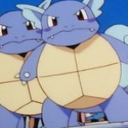

In [5]:
len(multi_images)
display(Image.fromarray(multi_images[3181]))

In [6]:
# ======================
# Feature Extraction
# ======================
class FeatureExtractor:
    def __init__(self, sift_kmeans=None):
        if USE_SIFT:
            self.sift = cv2.SIFT_create()
            self.kmeans = sift_kmeans
        self.scaler_bin = StandardScaler()
        self.scaler_multi = StandardScaler()

    def extract_basic_features(self, img):
        """Enhanced color-aware feature extraction"""
        # --- HOG Features (Multi-channel) ---
        hog_features = []
        for channel in range(3):
            # Using block normalization 'L2-Hys'
            hog_feat = hog(
                img[:, :, channel],
                orientations=HOG_ORIENTATIONS,
                pixels_per_cell=HOG_PIXELS_PER_CELL,
                cells_per_block=HOG_CELLS_PER_BLOCK,
                block_norm='L2-Hys'
            )
            hog_features.append(hog_feat)
        hog_features = np.concatenate(hog_features)
        
        # --- LBP Features ---
        # Convert to LAB for robust texture representation.
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        lbp_features = []
        P = 8  # Number of circularly symmetric neighbor set points
        R = 1  # Radius
        n_bins_lbp = P + 2  # For uniform patterns
        for channel in range(3):
            lbp = local_binary_pattern(lab[:, :, channel], P=P, R=R, method='uniform')
            # Use the appropriate number of bins for uniform LBP
            hist, _ = np.histogram(lbp.ravel(), bins=n_bins_lbp, range=(0, n_bins_lbp))
            # Normalize histogram to have unit sum
            hist = hist.astype('float')
            hist /= (hist.sum() + 1e-7)
            lbp_features.append(hist)
        lbp_features = np.concatenate(lbp_features)
        
        # --- Color Histograms ---
        # Compute histograms in both HSV and LAB color spaces.
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        color_features = []
        
        # HSV histograms:
        # Note: OpenCV represents H in the range [0,180] for 8-bit images.
        h_hist, _ = np.histogram(hsv[:, :, 0].ravel(), bins=COLOR_BINS, range=(0, 180))
        s_hist, _ = np.histogram(hsv[:, :, 1].ravel(), bins=COLOR_BINS, range=(0, 256))
        v_hist, _ = np.histogram(hsv[:, :, 2].ravel(), bins=COLOR_BINS, range=(0, 256))
        # Normalize each histogram
        h_hist = h_hist.astype('float') / (h_hist.sum() + 1e-7)
        s_hist = s_hist.astype('float') / (s_hist.sum() + 1e-7)
        v_hist = v_hist.astype('float') / (v_hist.sum() + 1e-7)
        color_features.extend([h_hist, s_hist, v_hist])
        
        # LAB histograms:
        for channel in range(3):
            lab_hist, _ = np.histogram(lab[:, :, channel].ravel(), bins=COLOR_BINS, range=(0, 256))
            lab_hist = lab_hist.astype('float') / (lab_hist.sum() + 1e-7)
            color_features.append(lab_hist)
        color_features = np.concatenate(color_features)
        
        # --- Final Feature Vector ---
        return np.concatenate([hog_features, lbp_features, color_features])

    def extract_sift_features(self, img):
        """Color-enhanced SIFT using dominant color channel.
           Note: Consider using a dense sampling strategy if keypoint detection is too sparse.
        """
        variances = [np.var(img[:, :, i]) for i in range(3)]
        dominant_channel = np.argmax(variances)
        _, des = self.sift.detectAndCompute(img[:, :, dominant_channel], None)
        if des is None or len(des) < 5:
            return np.zeros(SIFT_CLUSTERS)
        clusters = self.kmeans.predict(des)
        return np.bincount(clusters, minlength=SIFT_CLUSTERS)

    def extract_all_features(self, img):
        basic = self.extract_basic_features(img)
        if USE_SIFT:
            sift = self.extract_sift_features(img)
            return np.hstack([basic, sift])
        return np.hstack([basic])


In [7]:
# ======================
# Training Pipeline
# ======================
def train_sift_codebook(images):
    sift = cv2.SIFT_create()
    descriptors = []
    
    for img in images:
        variances = [np.var(img[:, :, i]) for i in range(3)]
        dominant_channel = np.argmax(variances)
        _, des = sift.detectAndCompute(img[:, :, dominant_channel], None)
        if des is not None:
            descriptors.append(des)
    
    if len(descriptors) == 0:
        raise ValueError("No SIFT descriptors found in any image!")
    
    all_descriptors = np.vstack(descriptors)
    kmeans = MiniBatchKMeans(n_clusters=SIFT_CLUSTERS, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans

if USE_SIFT:
    print("Training SIFT codebook...")
    sift_kmeans = train_sift_codebook(multi_images)
    joblib.dump(sift_kmeans, os.path.join(MODEL_SAVE_DIR, 'sift_kmeans.pkl'))
            # Initialize feature extractor        
    fe = FeatureExtractor(sift_kmeans)
else:
    fe = FeatureExtractor()



Training SIFT codebook...


In [8]:
# ======================
# Feature Extraction for Multi-class Classification
# ======================
print("\nTraining multi-class classifiers...")
le = LabelEncoder()
y_multi = le.fit_transform(multi_labels)
    
print("Extracting features...")
X_multi = [fe.extract_all_features(img) for img in tqdm(multi_images, desc='Processing images')]
X_multi = fe.scaler_multi.fit_transform(X_multi)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
X_multi, y_multi, test_size=0.2, stratify=y_multi, random_state=42)

pca_multi = None
if USE_PCA:
    pca_multi = PCA(n_components=0.95, random_state=42)
    X_train_multi = pca_multi.fit_transform(X_train_multi)
    X_test_multi = pca_multi.transform(X_test_multi)
    joblib.dump(pca_multi, os.path.join(MODEL_SAVE_DIR, 'pca_multi.pkl'))


Training multi-class classifiers...
Extracting features...


Processing images: 100%|██████████| 3182/3182 [00:39<00:00, 79.85it/s]


In [56]:
# Define multi-class models along with their parameter grids.
models = {
#'XGBoost': (XGBClassifier(random_state=42), {
#    'n_estimators': [50],
#    'learning_rate': [0.1],
#    'max_depth': [3]
#}),
#'SVM-RBF': (SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced'), {
#    'C': [1],
#    'gamma': ['scale']
#}),
#'kNN': (KNeighborsClassifier(weights='distance'), {
#    'n_neighbors': [5],
#    'weights': ['uniform']
#}),
'RForest': (RandomForestClassifier(random_state=42, class_weight='balanced'), {
    'n_estimators': [100],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [4],
    'max_features': [None],
    'n_jobs': [-1],
    'class_weight': ["balanced"],
    'verbose': [1]
})
}
for model_name, (model, param_grid) in models.items():
    if DO_HYPERPARAMETER_TUNING:
        print(f"\nTuning {model_name}...")
        grid = GridSearchCV(
            model, param_grid, cv=3, scoring='accuracy', n_jobs=8, verbose=2
        )
        grid.fit(X_train_multi, y_train_multi)
        print(f"Best parameters for {model_name}:", grid.best_params_)
        best_model = grid.best_estimator_
    else:
        best_model = model.fit(X_train_multi, y_train_multi)
    
    y_pred = best_model.predict(X_test_multi)
    print(f"\n{model_name} Performance:")
    print(classification_report(le.inverse_transform(y_test_multi), 
                                le.inverse_transform(y_pred)))
      
    joblib.dump(best_model, os.path.join(MODEL_SAVE_DIR, f'multi_clf_{model_name.lower()}.pkl'))

joblib.dump(fe.scaler_bin, os.path.join(MODEL_SAVE_DIR, 'scaler_bin.pkl'))
joblib.dump(fe.scaler_multi, os.path.join(MODEL_SAVE_DIR, 'scaler_multi.pkl'))
joblib.dump(le, os.path.join(MODEL_SAVE_DIR, 'label_encoder.pkl'))
    
print("\nTraining complete! Models saved to:", MODEL_SAVE_DIR)


Tuning RForest...
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   58.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END class_weight=balanced, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100, n_jobs=-1, verbose=1; total time= 4.5min


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END class_weight=balanced, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100, n_jobs=-1, verbose=1; total time= 4.5min


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.6min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END class_weight=balanced, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100, n_jobs=-1, verbose=1; total time= 4.6min


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   29.4s


Best parameters for RForest: {'class_weight': 'balanced', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'verbose': 1}

RForest Performance:
              precision    recall  f1-score   support

   Blastoise       0.75      0.70      0.73        57
   Bulbasaur       0.76      0.84      0.80        56
   Charizard       0.50      0.44      0.47        41
  Charmander       0.70      0.65      0.67        48
  Charmeleon       0.73      0.78      0.75        58
     Ivysaur       0.78      0.63      0.70        60
     Pikachu       0.85      0.70      0.76        79
      Raichu       0.64      0.74      0.69        66
    Squirtle       0.70      0.65      0.67        62
    Venusaur       0.61      0.76      0.68        55
   Wartortle       0.66      0.76      0.71        55

    accuracy                           0.70       637
   macro avg       0.70      0.70      0.69       637
weighted avg       0.71  

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.0s finished


In [54]:
# ======================
# Inference Pipeline
# ======================
class PokemonDetector:
    def __init__(self, model_name='rforest'):
        if USE_SIFT:
            self.sift_kmeans = joblib.load(os.path.join(MODEL_SAVE_DIR, 'sift_kmeans.pkl'))
            self.fe = FeatureExtractor(self.sift_kmeans)
        else:
            self.fe = FeatureExtractor()
        self.multi_clf = joblib.load(os.path.join(MODEL_SAVE_DIR, f'multi_clf_{model_name.lower()}.pkl'))
        self.le = joblib.load(os.path.join(MODEL_SAVE_DIR, 'label_encoder.pkl'))
        self.scaler_bin = joblib.load(os.path.join(MODEL_SAVE_DIR, 'scaler_bin.pkl'))
        self.scaler_multi = joblib.load(os.path.join(MODEL_SAVE_DIR, 'scaler_multi.pkl'))
        
        self.use_pca = USE_PCA
        if self.use_pca:
            self.pca_bin = joblib.load(os.path.join(MODEL_SAVE_DIR, 'pca_bin.pkl'))
            self.pca_multi = joblib.load(os.path.join(MODEL_SAVE_DIR, 'pca_multi.pkl'))
    
    def predict(self, image_path):
        img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if img is None:
            return []
        predictions = []

        img_resized = transform_image(img)
        features = self.fe.extract_all_features(img_resized)
        features = self.scaler_multi.transform([features])
        if self.use_pca:
                features = self.pca_multi.transform(features)
        
        pred_probs = self.multi_clf.predict_proba(features)[0]
        pred = np.argmax(pred_probs)
        
        class_labels = self.le.inverse_transform(np.arange(len(pred_probs)))  # Get class labels
        for label, prob in zip(class_labels, pred_probs):
            print(f"Class: {label}, Probability: {prob:.4f}")
        
        
        prediction = self.le.inverse_transform([pred])[0]
        predictions.append(prediction)

        print(prediction, pred_probs[pred])
        display(Image.fromarray(img_resized))
        
        return list(set(predictions))

Class: Blastoise, Probability: 0.0055
Class: Bulbasaur, Probability: 0.0113
Class: Charizard, Probability: 0.0470
Class: Charmander, Probability: 0.1163
Class: Charmeleon, Probability: 0.1055
Class: Ivysaur, Probability: 0.0064
Class: Pikachu, Probability: 0.0721
Class: Raichu, Probability: 0.5982
Class: Squirtle, Probability: 0.0069
Class: Venusaur, Probability: 0.0000
Class: Wartortle, Probability: 0.0309
Raichu 0.5982291497158156


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  50 out of  50 | elapsed:    0.0s finished


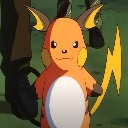

Predictions on test_raichu.png: [np.str_('Raichu')]
Class: Blastoise, Probability: 0.2701
Class: Bulbasaur, Probability: 0.0040
Class: Charizard, Probability: 0.0570
Class: Charmander, Probability: 0.0044
Class: Charmeleon, Probability: 0.0159
Class: Ivysaur, Probability: 0.0042
Class: Pikachu, Probability: 0.0477
Class: Raichu, Probability: 0.0112
Class: Squirtle, Probability: 0.2334
Class: Venusaur, Probability: 0.0109
Class: Wartortle, Probability: 0.3411
Wartortle 0.34108035995346503


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  50 out of  50 | elapsed:    0.0s finished


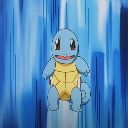

Predictions on test_squirtle.png: [np.str_('Wartortle')]
Class: Blastoise, Probability: 0.0570
Class: Bulbasaur, Probability: 0.0104
Class: Charizard, Probability: 0.1455
Class: Charmander, Probability: 0.2838
Class: Charmeleon, Probability: 0.0941
Class: Ivysaur, Probability: 0.0086
Class: Pikachu, Probability: 0.1510
Class: Raichu, Probability: 0.1390
Class: Squirtle, Probability: 0.0148
Class: Venusaur, Probability: 0.0575
Class: Wartortle, Probability: 0.0384
Charmander 0.28376977433116846


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done  50 out of  50 | elapsed:    0.0s finished


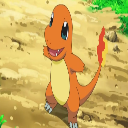

Predictions on test_charmander.png: [np.str_('Charmander')]


In [55]:
# Example usage
detector = PokemonDetector(model_name='rforest')

print("Predictions on test_raichu.png:", detector.predict("manual-test-images/test_raichu.png"))
print("Predictions on test_squirtle.png:", detector.predict("manual-test-images/test_squirtle.png"))
print("Predictions on test_charmander.png:", detector.predict("manual-test-images/test_charmander.png"))